In [2]:
from packages import *
import pandas as pd
import tensorflow as tf
from datetime import datetime, timedelta
import time
import tensorflow.keras.backend as K
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import *
from tensorflow.data.experimental import AUTOTUNE
from sklearn.metrics import classification_report, precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import shuffle
from collections import Counter
%load_ext autoreload
%autoreload 2

# Model
We will be building our models in this notebook.

Some configuration required for tensorflow.

In [3]:
tf.config.gpu.set_per_process_memory_growth(True)
tf.config.gpu.set_per_process_memory_fraction(.90)
tf.keras.backend.set_image_data_format('channels_last')

## Dataset

In [4]:
glove_dim = 300
max_length = 300
chunk_count = 100
random_seed = np.random.randint(0, 1000000000)
print('using random_seed: {}'.format(random_seed))
splits = ['train', 'val', 'test'] #60:20:20

using random_seed: 195698938


In [5]:
tf_text_filenames = [os.path.join(DATASET_DIR, 'preprocessed', 'tfrecord', 'xext',  #xext temporarily
                                  'review-text-{:02d}.tf'.format(i)) for i in range(chunk_count)]
tf_ix_filenames = [os.path.join(DATASET_DIR, 'preprocessed', 'tfrecord', 'ix', 
                                  'review-ix-{:02d}.tf'.format(i)) for i in range(chunk_count)]
all_stars = (load_data({'review': ['stars']})['review']['stars'] - 1).astype(np.int32)# this is so that stars are 0-indexed
N = {}
stars_chunked = all_stars.reshape((chunk_count, 6685900//chunk_count))

In [6]:
class_weights = compute_class_weight('balanced', [0, 1, 2, 3, 4], all_stars)
class_weights = {'five': class_weights, 'ternary': np.array([class_weights[0], class_weights[1:4].sum() , class_weights[4]])}

In [7]:
tf_text, tf_ix, stars= {}, {}, {}

In [8]:
tf_text['train'], tf_text_filenames_val_test, tf_ix['train'], tf_ix_filenames_val_test, stars['train'], stars_val_test \
= train_test_split(tf_text_filenames, tf_ix_filenames, stars_chunked, random_state=random_seed, test_size = .4)

In [9]:
tf_text['val'], tf_text['test'], tf_ix['val'], tf_ix['test'], stars['val'], stars['test'] \
= train_test_split(tf_text_filenames_val_test, tf_ix_filenames_val_test, stars_val_test, random_state=random_seed, test_size = .5)

In [10]:
for split in splits:
    stars[split] = stars[split].reshape(np.product(stars[split].shape))
    N[split] = len(stars[split])

In [11]:
print('({}:{}:{})'.format(len(tf_text['train']), len(tf_text['val']), len(tf_text['test'])))

(60:20:20)


In [12]:
glove_lookup = load_pickle(os.path.join(GLOVE_DIR, 'glove-{}D-byte-float32.pkl'.format(glove_dim)))
keys_to_ix = load_pickle(os.path.join(GLOVE_DIR, 'glove-byte-keys_to_ix.pkl'))
ix_to_key = {value: key for key, value in keys_to_ix.items()}

In [13]:
unk_vector = np.mean(np.array(list(glove_lookup.values())), axis=0)
null_vector = np.zeros(glove_dim)
glove_lookup[UNK_KEY.encode('ascii')] = unk_vector #if using byte glove dict
glove_lookup[NULL_KEY.encode('ascii')] = null_vector

In [14]:
oops = 0
glove_lookup_array = []
for i in range(len(ix_to_key)):
    if ix_to_key[i] not in glove_lookup:
        oops+=1
    glove_lookup_array.append(glove_lookup.get(ix_to_key[i], null_vector))
glove_lookup_array = np.array(glove_lookup_array, dtype=np.float32)
print('oops {} times.'.format(oops))

oops 1 times.


In [15]:
@tf.function
def get_review_length(review):
    return tf.cast(tf.reduce_sum(tf.cast(tf.not_equal(review, 0), tf.int8)), tf.int32)

In [16]:
@tf.function
def _parse_function(proto, to_ix):
    # define your tfrecord again. Remember that you saved your image as a string.
    keys_to_features = {'review': tf.io.FixedLenFeature([300,], tf.int64) if to_ix else tf.io.FixedLenFeature([300,], tf.string),}
    
    # Load one example
    parsed_features = tf.io.parse_single_example(proto, keys_to_features)
    
    return parsed_features 

In [17]:
embedding = tf.constant(glove_lookup_array)
@tf.function
def embed(tensor):
    return tf.gather(embedding, tensor)

In [18]:
@tf.function
def add_channel(tensor):
    return tf.expand_dims(tensor, -1)

In [19]:
def make_dataset(batch_size, to_embed=True, to_ix=True, to_str=False, channelize=True, to_ternary_task=False, features= {}): 
    '''
    Note: once created dataset remains the same from iteration to iteration. 
    In Keras.fit, once given steps_per_epoch the data for epochs are not the same.
    Validation data is the same.
    If cell is rerun, then the same order of data will be fed.
    '''
    if to_ternary_task:
        star_mapping = tf.constant([0, 1, 1, 1, 2], dtype=tf.int32)
    def _prepare_star(star):
        if to_ternary_task: return {'stars': tf.gather(star_mapping, star)}
        return {'stars': star}
    def _parse_transform(x):
        parsed = _parse_function(x, to_ix or to_embed)['review']
        out = {key: f(x) for key, f in features.items()}
        if to_ix:
            out['review-ix'] = tf.cast(parsed, tf.int32)
        if to_embed:
            if channelize:
                out['review-embed'] = add_channel(embed(parsed))
            else:
                out['review-embed'] = embed(parsed)
        if to_str:
            pass  
        return out   
    
    shuffle_buffer_size = batch_size * 100
    prefetch_buffer_size = 4
    if to_embed or to_ix: 
        files = tf_ix
    else:
        files = tf_text
    dataset = {}
    num_batches = {}
    for split in splits:
        dataset[split] = tf.data.TFRecordDataset(files[split])
        stars_dataset = tf.data.Dataset.from_tensor_slices(stars[split])
        dataset[split] = tf.data.Dataset.zip((dataset[split], stars_dataset))
        dataset[split] = dataset[split].shuffle(shuffle_buffer_size)
        dataset[split] = dataset[split].repeat()
        dataset[split] = dataset[split].map(lambda x, y: (_parse_transform(x), _prepare_star(y)), num_parallel_calls=12)
        dataset[split] = dataset[split].batch(batch_size)
        dataset[split] = dataset[split].prefetch(prefetch_buffer_size)
        num_batches[split] = N[split] // batch_size
    print('num_batches: {}, batch_size: {}, shuffle_buffer_size: {}, prefetch_buffer_size: {}'.format(num_batches, batch_size, 
                                                                                 shuffle_buffer_size, prefetch_buffer_size))
    return dataset, num_batches

In [20]:
batch_size = 64
dataset, num_batches = make_dataset(batch_size=batch_size, to_embed=True, to_ix=True, channelize=True, to_ternary_task=True,)

num_batches: {'train': 62680, 'val': 20893, 'test': 20893}, batch_size: 64, shuffle_buffer_size: 6400, prefetch_buffer_size: 4


In [49]:
%%time
for i, (x, y) in enumerate(dataset['train']):
    if i == 500:
        break
for i, (x, y) in enumerate(dataset['train']):
    if i == 500:
        break
# Wall time: 30.1 --> 14.2 --> 4.3 s wow

CPU times: user 41.2 s, sys: 8.27 s, total: 49.4 s
Wall time: 4.19 s


In [22]:
for x_init, y_init in dataset['train']:break

# Models

### BabyBlueberry
Convolutional Model with GLoVe embeddings.

In [68]:
@rename('all_acc')
def all_class_accuracy(y_true, y_pred):
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred) 

def one_class_recall(label):
    @rename('{}_recalll'.format(label))
    def single_class_recall(y_true, y_pred): # (64, 1), (64, 5) should return (64,)
        truth = K.flatten(K.cast(y_true, 'int32'))
        preds = K.cast(K.argmax(y_pred, axis=-1), 'int32')
        recall_mask = K.cast(K.equal(truth, label), 'int32')        
        recall = K.cast(K.equal(preds, truth), 'int32') * recall_mask
        recall = K.cast(K.sum(recall) / K.maximum(K.sum(recall_mask), 1), 'float32')
        recall =  K.ones(batch_size, dtype='float32') * recall
        return recall
    return single_class_recall

def one_class_precision(label):
    @rename('{}_precision'.format(label))
    def single_class_precision(y_true, y_pred): # (64, 1), (64, 5) should return (64,)
        truth = K.flatten(K.cast(y_true, 'int32'))
        preds = K.cast(K.argmax(y_pred, axis=-1), 'int32')
        precision_mask = K.cast(K.equal(preds, label), 'int32')          
        precision = K.cast(K.equal(preds, truth), 'int32') * precision_mask
        precision = K.cast(K.sum(precision) / K.maximum(K.sum(precision_mask), 1), 'float32')
        precision =  K.ones(batch_size, dtype='float32') * precision
        return precision
    return single_class_precision

In [69]:
star_metrics = [all_class_accuracy]
star_metrics += [one_class_recall(i) for i in range(3)] + [one_class_precision(i) for i in range(3)]

In [70]:
def get_kernel_spec(filters, height, width):
    return {'filters':filters, 'height': height, 'width': width}

In [73]:
Embedding?

Init signature:
Embedding(
    input_dim,
    output_dim,
    embeddings_initializer='uniform',
    embeddings_regularizer=None,
    activity_regularizer=None,
    embeddings_constraint=None,
    mask_zero=False,
    input_length=None,
    **kwargs,
)
Docstring:     
Turns positive integers (indexes) into dense vectors of fixed size.

e.g. `[[4], [20]] -> [[0.25, 0.1], [0.6, -0.2]]`

This layer can only be used as the first layer in a model.

Example:

```python
model = Sequential()
model.add(Embedding(1000, 64, input_length=10))
# the model will take as input an integer matrix of size (batch,
# input_length).
# the largest integer (i.e. word index) in the input should be no larger
# than 999 (vocabulary size).
# now model.output_shape == (None, 10, 64), where None is the batch
# dimension.

input_array = np.random.randint(1000, size=(32, 10))

model.compile('rmsprop', 'mse')
output_array = model.predict(input_array)
assert output_array.shape == (32, 10, 64)
```

Arguments:
  input_dim

In [92]:
Concatenate?

Init signature: Concatenate(axis=-1, **kwargs)
Docstring:     
Layer that concatenates a list of inputs.

It takes as input a list of tensors,
all of the same shape except for the concatenation axis,
and returns a single tensor, the concatenation of all inputs.

Arguments:
    axis: Axis along which to concatenate.
    **kwargs: standard layer keyword arguments.
File:           ~/anaconda3/envs/yelp-nlu_3.6/lib/python3.6/site-packages/tensorflow/python/keras/layers/merge.py
Type:           type
Subclasses:     


In [110]:
class BabyBlueberry:
    
    def build(input_shape=(max_length, glove_dim, 1), dropout_rate=.4, lstm_units = 500,
              kernels=[get_kernel_spec(100, 3, glove_dim), get_kernel_spec(100, 4, glove_dim), get_kernel_spec(100, 5, glove_dim)],  
              out_units=5):
        ix_input = Input(shape= (max_length,), name='review-ix')
        glove_input = Input(shape=input_shape, name='review-embed')
        
        embedding = Embedding(input_dim=len(glove_lookup_array), output_dim=glove_dim, 
                              input_length=max_length, name='trained_embed')(ix_input)
        channel_embedding = Reshape(target_shape=(max_length, glove_dim, 1), name='reshape_embed')(embedding)
        flat_glove = Reshape(target_shape=(max_length, glove_dim), name='reshape_glove')(glove_input)
        
        combined_embedding = Concatenate(name='concat_embed')([channel_embedding, glove_input])
        branches = []
        names = {}
        for kernel in kernels:
            if (kernel['height'], kernel['width']) in names:
                names[(kernel['height'], kernel['width'])] = i = names[(kernel['height'], kernel['width'])] + 1
            else:
                names[(kernel['height'], kernel['width'])] = i = 1
            branch = Conv2D(kernel['filters'], (kernel['height'], kernel['width']), activation='relu', 
                            name='conv_{}_{}_{}'.format(kernel['height'], kernel['width'], i), 
                            padding='valid')(combined_embedding)
            branch = GlobalMaxPool2D(name='pool_{}_{}_{}'.format(kernel['height'], kernel['width'], i))(branch)
            branches.append(branch)
        
        lstm_out = LSTM(units=lstm_units, name='lstm')(flat_glove)
        x = Concatenate(name='concat_conv_lstm')(branches + [lstm_out])
        x = Dropout(rate=dropout_rate, name='dropout')(x)
        x = Dense(500, activation='relu', name='dense')(x)
        out = Dense(out_units, activation='softmax', name='stars')(x)
        
        return tf.keras.models.Model(inputs={'review-embed':glove_input, 'review-ix': ix_input}, 
                                     outputs={'stars': out}, name='Blueberry')
        
    @tf.function
    def loss_fn(truth, logits):
        loss = tf.keras.losses.sparse_categorical_crossentropy(truth, logits)
        return loss

In [111]:
kernels = [get_kernel_spec(filters=100, height=h, width=glove_dim) for h in [2, 3, 4, 5, 10]]
baby = BabyBlueberry.build(kernels=kernels, dropout_rate=.3, out_units=3, lstm_units=500)
adam = tf.keras.optimizers.Adam()
baby.compile(optimizer=adam, metrics={'stars': star_metrics} ,loss={'stars': BabyBlueberry.loss_fn})

W0607 18:43:32.812074 140093777598272 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x7f69583f58d0>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.


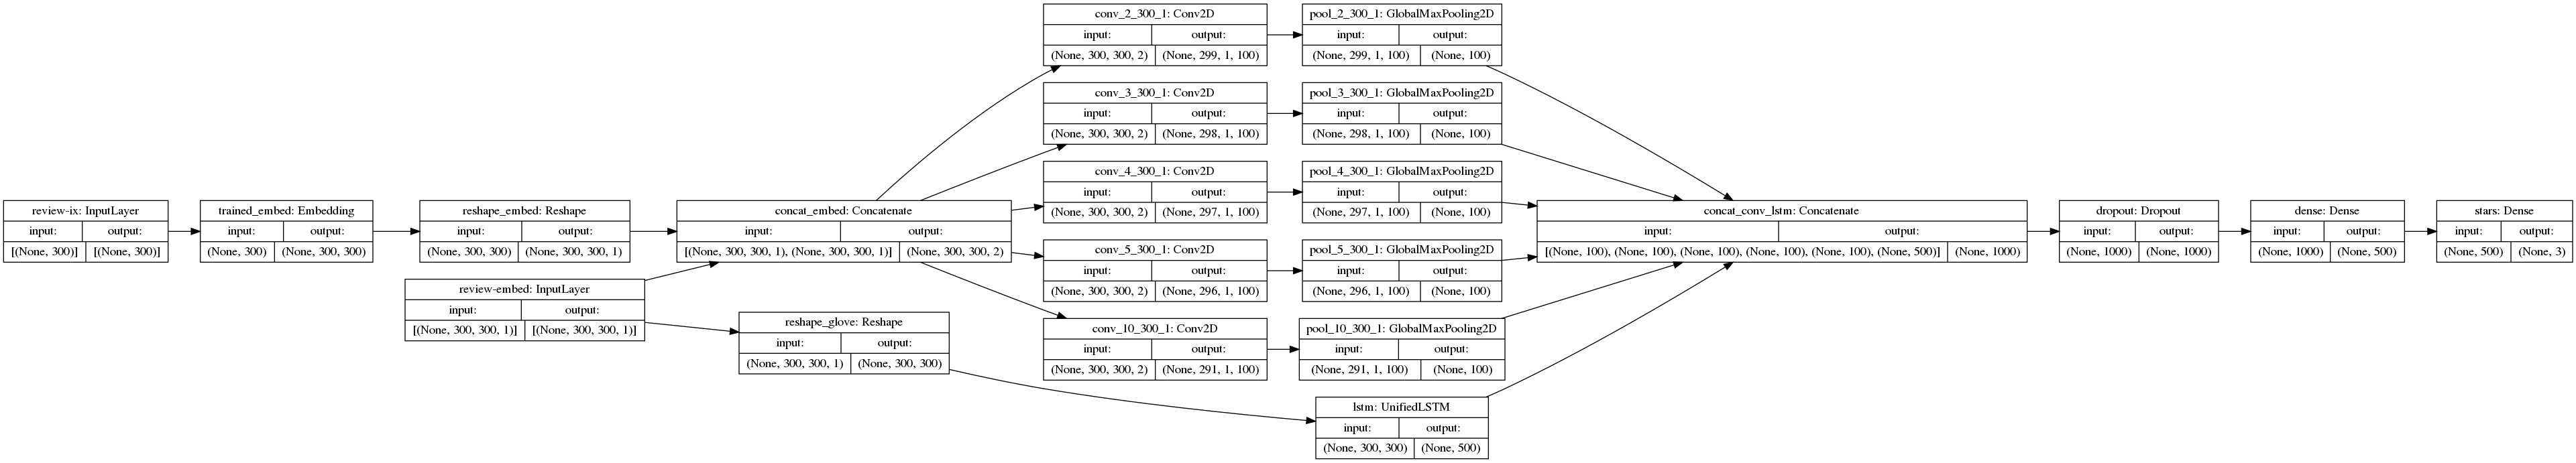

In [112]:
plot_model(baby, show_shapes=True, rankdir='LR', to_file='lstm_conv_model.png')

In [109]:
log_dir = os.path.join(SRC_DIR, 'logs', 'CONV-LSTM-{}'.format(datetime.fromtimestamp(time.time()).strftime('%d-%m_%H-%M-%S')))
tb = tf.keras.callbacks.TensorBoard(log_dir=log_dir, write_graph=False, update_freq='batch')

_=baby.fit(dataset['train'], steps_per_epoch=100, epochs=2, 
                             validation_data= dataset['val'], validation_steps=10,
                             callbacks=[tb], class_weight=class_weights['ternary'], verbose=1)

Epoch 1/2
 22/100 [=====>........................] - ETA: 51s - loss: 0.9792 - all_acc: 0.5085 - 0_recalll: 0.1343 - 1_recalll: 0.5655 - 2_recalll: 0.6219 - 0_precision: 0.2435 - 1_precision: 0.4458 - 2_precision: 0.5834

KeyboardInterrupt: 

In [ ]:
i = 12
np.array_equal(store_1[i].numpy(), store_2[i].numpy())

In [ ]:
baby.summary()

In [ ]:
dataset['train']

In [ ]:
store = np.array(store)

In [67]:
truth, predictions = [], []
for x, y in dataset['val'].take(10):
    pred = baby.predict_on_batch(x)
    truth.append(y['stars'].numpy())
    predictions.append(tf.argmax(pred['stars'], axis=-1).numpy())
predictions=np.array(predictions).flatten()
truth = np.array(truth).flatten()
print(classification_report(truth, predictions))

              precision    recall  f1-score   support

           0       0.78      0.75      0.77       118
           1       0.72      0.65      0.68       246
           2       0.76      0.84      0.80       276

    accuracy                           0.75       640
   macro avg       0.75      0.75      0.75       640
weighted avg       0.75      0.75      0.75       640



## Automated Testing

In [ ]:
try:
    histories
except:
    histories, reports = { }, { }

In [ ]:
possible_heights = list(np.arange(5, step=1)+2) + list(np.arange(10, 50, step=5)) #+ list(np.arange(50, 101, step=10))
possible_num_branches = list(np.arange(4, 11, step=2))
possible_filters = list(np.arange(200, 501, step=100))
possible_dropouts = list(np.arange(.1, .51, step=.1))

In [ ]:
print('possible_heights: {}'.format(possible_heights))
print('possible_num_branches: {}'.format(possible_num_branches))
print('possible_filters: {}'.format(possible_filters))
print('possible_dropouts: {}'.format(possible_dropouts))

In [ ]:
def save_report_histories():
    save_pickle('histories.pkl', reports)
    save_pickle('reports.pkl', reports)


In [ ]:
def load_report_histories():
    return (load_pickle('histories.pkl'),
            load_pickle('reports.pkl'))

In [ ]:
possible_heights = set(possible_heights) #+ list(np.arange(50, 101, step=10)))
possible_num_branches = shuffle(possible_num_branches)
possible_filters = shuffle(possible_filters)
possible_dropouts = shuffle(possible_dropouts)
histories, reports = load_report_histories()
i = 0
for num_branches in possible_num_branches:
    subsets = find_subsets_of_n(possible_heights, num_branches)
    subsets = shuffle(subsets)
    for heights in subsets:
        for filters in possible_filters:
            for dropout_rate in possible_dropouts:
                
                params = (tuple(heights), filters, dropout_rate)
                if params in reports:
                    continue
                print(params)
                kernels = [get_kernel_spec(filters=filters, height=h, width=glove_dim) for h in heights]
                baby = BabyBlueberry.build(kernels=kernels, dropout_rate=dropout_rate)
                adam = tf.keras.optimizers.Adam()
                baby.compile(optimizer=adam, metrics={'stars': star_metrics} ,loss={'stars': BabyBlueberry.loss_fn})
                log_dir = os.path.join(SRC_DIR, 'logs', 'CONV-{}'.format(datetime.fromtimestamp(time.time()).strftime('%H-%M-%S_%m-%d')))
                tb = tf.keras.callbacks.TensorBoard(log_dir=log_dir, write_graph=False, update_freq='batch')
                histories[params] = baby.fit(dataset['train'], steps_per_epoch=100, epochs=5, 
                                             validation_data= dataset['val'], validation_steps=10,
                                             callbacks=[tb], class_weight=class_weights, verbose=1)
                predictions, truth = [], []
                for x, y in dataset['val'].take(100):
                    pred = baby.predict_on_batch(x)
                    truth.append(y['stars'].numpy())
                    predictions.append(tf.argmax(pred['stars'], axis=-1).numpy())
                predictions=np.array(predictions).flatten()
                truth = np.array(truth).flatten()
                reports[params] = classification_report(truth, predictions)
                print(reports[params])
                save_report_histories()

In [ ]:
save_pickle('reports.pkl', reports)
save_pickle('histories.pkl', histories)

In [ ]:
dataset['train'].shuffle

In [ ]:
for x, y in dataset['train']:break
truth = y['stars']
pred = baby(x['review'])['stars']

In [ ]:
print(classification_report(truth, predictions))